In [2]:
from IPython.display import Image

In [3]:
# Figure 1
Image(url= "http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

In [4]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import cntk as C

%matplotlib inline

C:\Users\Dell\AppData\Local\Programs\Python\Python36\Lib\site-packages\cntk\cntk_py_init.py:84: UserWarning: 

################################################ Missing optional dependency (GPU-Specific) ################################################
   CNTK may crash if the component that depends on those dependencies is loaded.
   Visit https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu-specific-packages for more information.
############################################################################################################################################
If you intend to use CNTK without GPU support, you can ignore the (likely) GPU-specific warning!
############################################################################################################################################

  warnings.warn(WARNING_MSG_GPU_ONLY % ('GPU-Specific', 'https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu-specific-pa

In the block below, we check if we are running this notebook in the CNTK internal test machines by looking for environment variables defined there. We then select the right target device (GPU vs CPU) to test this notebook. In other cases, we use CNTK's default policy to use the best available device (GPU, if available, else CPU).

In [5]:
# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

In [6]:
# Test for CNTK version
if not C.__version__ == "2.0":
    raise Exception("this lab is designed to work with 2.0. Current Version: " + C.__version__) 

Exception: this lab is designed to work with 2.0. Current Version: 2.6

In [8]:
# Ensure we always get the same amount of randomness
np.random.seed(0)
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()

# Define the data dimensions
input_dim = 784
num_output_classes = 10

In [9]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features   = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [11]:
# Ensure the training and test data is generated and available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.
data_found = False
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break
if not data_found:
    raise ValueError("Please generate the data by completing Lab1_MNIST_DataLoader")
print("Data directory is {0}".format(data_dir))

Data directory is data\MNIST


In [12]:
num_hidden_layers = 2
hidden_layers_dim = 400

In [13]:
input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

## Multi-layer Perceptron setup

The code below is a direct translation of the model shown above.

In [14]:
def create_model(features):
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.ops.relu):
            h = features
            for _ in range(num_hidden_layers):
                h = C.layers.Dense(hidden_layers_dim)(h)
            r = C.layers.Dense(num_output_classes, activation = None)(h)
            return r
        
z = create_model(input)

In [15]:
# Scale the input to 0-1 range by dividing each pixel by 255.
z = create_model(input/255.0)

In [16]:
loss = C.cross_entropy_with_softmax(z, label)

In [17]:
label_error = C.classification_error(z, label)

In [18]:
# Instantiate the trainer object to drive the model training
learning_rate = 0.2
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, label_error), [learner])

First let us create some helper functions that will be needed to visualize different functions associated with training.

In [19]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

In [20]:
# Initialize the parameters for the trainer
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

In [21]:
# Create the reader to training data set
reader_train = create_reader(train_file, True, input_dim, num_output_classes)

# Map the data streams to the input and labels.
input_map = {
    label  : reader_train.streams.labels,
    input  : reader_train.streams.features
} 

# Run the trainer on and perform model training
training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    
    # Read a mini batch from the training data file
    data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
    
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 2.2945, Error: 92.19%
Minibatch: 500, Loss: 0.2512, Error: 10.94%
Minibatch: 1000, Loss: 0.0880, Error: 1.56%
Minibatch: 1500, Loss: 0.1395, Error: 4.69%
Minibatch: 2000, Loss: 0.0147, Error: 0.00%
Minibatch: 2500, Loss: 0.0184, Error: 1.56%
Minibatch: 3000, Loss: 0.0103, Error: 0.00%
Minibatch: 3500, Loss: 0.0319, Error: 1.56%
Minibatch: 4000, Loss: 0.0311, Error: 1.56%
Minibatch: 4500, Loss: 0.0244, Error: 1.56%
Minibatch: 5000, Loss: 0.0055, Error: 0.00%
Minibatch: 5500, Loss: 0.0022, Error: 0.00%
Minibatch: 6000, Loss: 0.0062, Error: 0.00%
Minibatch: 6500, Loss: 0.0189, Error: 0.00%
Minibatch: 7000, Loss: 0.0095, Error: 0.00%
Minibatch: 7500, Loss: 0.0170, Error: 0.00%
Minibatch: 8000, Loss: 0.0022, Error: 0.00%
Minibatch: 8500, Loss: 0.0030, Error: 0.00%
Minibatch: 9000, Loss: 0.0013, Error: 0.00%


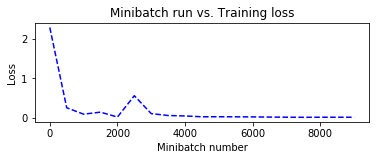

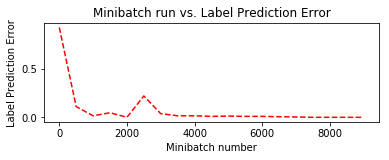

In [22]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

In [35]:
# Read the training data
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

test_input_map = {
    label  : reader_test.streams.labels,
    input  : reader_test.streams.features,
}

# Test data for trained model
test_minibatch_size = 64
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    
    # We are loading test data in batches specified by test_minibatch_size
    # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
    # with one pixel per dimension that we will encode / decode with the 
    # trained model.
    data = reader_test.next_minibatch(test_minibatch_size,
                                      input_map = test_input_map)

    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

# Average of evaluation errors of all test minibatches
print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

Average test error: 1.76%


In [24]:
out = C.softmax(z)

Let us test a small minibatch sample from the test data.

In [29]:
# Read the data for evaluation
reader_eval = create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 128
eval_input_map = {input: reader_eval.streams.features} 

data = reader_test.next_minibatch(eval_minibatch_size, input_map = test_input_map)

img_label = data[label].asarray()
img_data = data[input].asarray()
predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [30]:
# Find the index with the maximum value for both predicted as well as the ground truth
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [31]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [0, 5, 8, 6, 0, 3, 8, 1, 0, 3, 0, 4, 7, 4, 9, 2, 9, 5, 7, 1, 7, 1, 6, 6, 5]
Predicted: [0, 5, 8, 6, 0, 3, 8, 1, 0, 3, 0, 4, 7, 4, 9, 0, 9, 0, 7, 1, 7, 1, 6, 6, 5, 6, 0, 8, 7, 6, 4, 9, 9, 5, 3, 7, 4, 3, 0, 7, 6, 6, 1, 1, 3, 2, 1, 0, 0, 1, 2, 3, 4, 7, 8, 4, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 0, 8, 3, 9, 5, 5, 2, 6, 8, 4, 1, 7, 1, 2, 3, 5, 6, 9, 1, 1, 1, 2, 1, 2, 0, 7, 7, 5, 8, 2, 9, 8, 6, 7, 3, 4, 6, 8, 7, 0, 4, 2, 7, 7, 5, 4, 3, 4, 2, 8, 1, 5, 1, 0, 2]


As you can see above, our model is much better.  Do you see any mismatches?  

Let us visualize one of the test images and its associated label.  Do they match?

Image Label:  3


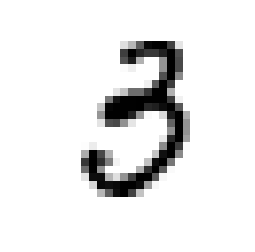

In [32]:
# Plot a random image
sample_number = 5
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)